<a href="https://colab.research.google.com/github/cicerotcv/iris-recognition/blob/master/projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Projeto de reconhecimento de Iris**

**Alunos:**

*   Cicero Tiago Carneiro Valentim
*   Evandro Fontana Romeiro


**Instalação do Módulo G6 (Gate 6)**

Documentação do Módulo G6: https://pypi.org/project/G6-iris-recognition/ 

Para instalar o módulo de reconhecimento de íris G6, seguir os passos abaixo:

1. Atualizar o módulo scikit-image do Google Colab:

In [1]:
from os import listdir, system, mkdir
import shutil
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

try:
    !pip3 install scikit-image --upgrade
    import skimage
    print("scikit-image already installed")
except ImportError:
    !pip3 install scikit-image --upgrade
    import skimage
    
try:
    import imutils
    print("imutils already installed")
except ImportError:
    system("pip3 install imutils")
    import imutils

scikit-image already installed
imutils already installed


In [2]:
def create_pickle(pickle_name: str = 'model.pickle'):
    if pickle_name not in listdir('./'):
        open(pickle_name, 'w+').close()

def git_clone(repo_url: str, output_dir: str):
    system(f"git clone {repo_url} {output_dir}")
    print(f"Git repository cloned into '{output_dir}'")


def clean_git(dir: str):
    # função que apaga .git da pasta {dir}
    pass

def put_text(img:np.ndarray, text:str):
    img = img.copy()
    font = cv.FONT_HERSHEY_SIMPLEX
    font_thickness = 2
    font_scale = 1
    (img_height, img_width, depth) = img.shape
    (text_width, text_height), baseline = cv.getTextSize(text, font, font_scale, font_thickness)
    x = (img_width - text_width)//2
    y = 5 + text_height + baseline
    cv.putText(img, text, (x, y), font, font_scale, (100, 0, 0), font_thickness, cv.LINE_AA)
    return img
    
def cv_imshow(img, text=None):
    if text != None:
        img = put_text(img, text)
    plt.figure(figsize = (20, 4))
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    plt.show()

def ensure_path_exists(path:str):
    source = "."
    for subfolder in path.strip('/').split('/'):
        next_level = source + '/' + subfolder
        if subfolder not in listdir(source):
            mkdir(next_level)
        source = next_level
        
def img_save(img, source_dir, category, img_name):
    source_tmp = source_dir + "_tmp"
    ensure_path_exists(f"{source_tmp}/{category}")
    full_path = f'{source_tmp}/{category}/{img_name}'
    cv.imwrite(full_path, img)

def gray2bgr(gray):
    return cv.cvtColor(gray, cv.COLOR_GRAY2BGR)

def bgr2gray(bgr):
    return cv.cvtColor(bgr, cv.COLOR_BGR2GRAY)

   2. Fazer um clone do módulo G6 Iris Recognition do repositório abaixo:

```python
tutorial_git_url = "https://github.com/lucianosilva-github/images-tutorial.git"
tutorial_output_dir = "images-tutorial"

git_clone(tutorial_git_url, tutorial_output_dir)
# não esquecer de deletar .git da pasta {tutorial_output_dir} 
```

   4. Criar o arquivo vazio model.pickle 

## Criação de funções úteis

### Função que realiza transformação linear na imagem

Função que realiza uma operação do tipo  $ final = \alpha\cdot x + \beta $, sendo particularmente útil para o aumento de contraste ou clareamento/escurecimento de imagens.

In [3]:
def increase_contrast(img: np.ndarray, alpha=1.5, beta=0):
    """
    `Contrast control (1.0-3.0)` \\
    `Brightness control (0-100)`
    """
    img = img.copy()
    adjusted = cv.convertScaleAbs(img, alpha=alpha, beta=beta)
    return adjusted

### Função que equaliza a escala imagem em escala de cinza

In [4]:
def white_equalizer(img: np.ndarray):
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_gray = cv.equalizeHist(img_gray)
    return cv.cvtColor(img_gray, cv.COLOR_GRAY2BGR)

### Função que "corrige o contraste" em imagens de baixo contraste. Equaliza a componente **V** da imagem convertida para HSV.

In [5]:
def fix_contrast(img: np.ndarray):
    img_copy = img.copy()
    img_hsv = cv.cvtColor(img_copy, cv.COLOR_BGR2HSV)
    (H,S,V) = cv.split(img_hsv)
    V = cv.equalizeHist(V)
    merge = cv.merge( (H,S,V) )
    return cv.cvtColor(merge, cv.COLOR_HSV2BGR)

### Função que aumenta a nitidez da imagem

In [6]:
def sharpen_img(img):
    img_copy = img.copy()
    kernel = np.array([[-1, -1, -1], 
                       [-1,  9, -1],
                       [-1, -1, -1]])
    img_copy = cv.filter2D(img_copy, -1, kernel)
    return img_copy

### Função que aplica "blur" na imagem, deixando-a um pouco menos granulada.

In [7]:
def blur_img(img, shape=(10,10)):
    return cv.blur(img, ksize=shape)

### Função que inverte a imagem

In [8]:
def invert_img(img:np.ndarray):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    invert = cv.bitwise_not(gray) 
    return cv.cvtColor(invert, cv.COLOR_GRAY2BGR)

### Função que appica correção de gamma na imagem.

In [9]:
def adjust_gamma(img, gamma=1.90):
    # https://lindevs.com/apply-gamma-correction-to-an-image-using-opencv/
    invGamma = 1 / gamma
 
    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)
 
    return cv.LUT(img, table)

In [10]:
def eq_bimodal(img: np.ndarray):
    img_gray = bgr2gray(img)

    _, img = cv.threshold(img_gray, 80, 255,  cv.THRESH_OTSU)

    return gray2bgr(img)

### Função que divide a imagem em blocos de _shape_ `tileGridSize` aplica equalização localizada

In [11]:
def apply_clahe(img: np.ndarray, clipLimit=2.0, tileGridSize=(8,8)):
    img_copy = img.copy()
    gray = bgr2gray(img_copy)
    mag = cv.createCLAHE(clipLimit, tileGridSize)
    mag_img = mag.apply(gray)
    return gray2bgr(mag_img)


### Função que aplica as anteriores condicionalmente

Essa função recebe uma imagem e sinais que ativam/desativam a aplicação das funções de transformação anteriores

In [12]:
def process_img(img_before: np.ndarray, equalize=False, contrast=False, alpha=1.8, beta=-10, gamma=1.9,
                blur_shape=(5,6), sharpen=True, blur=True, bimodal=True, clahe=True):
    img = img_before.copy()
    
    
    if clahe:
        img = apply_clahe(img, clipLimit=2.0, tileGridSize=(8,8))
    if bimodal:
        img = eq_bimodal(img)
    if sharpen:
        img = sharpen_img(img)
    if blur:
        img = blur_img(img, blur_shape)
    if equalize:
        img = white_equalizer(img)
    if contrast:
        img = fix_contrast(img)
    if alpha != 1 or beta != 0:
        img = increase_contrast(img, alpha=alpha, beta=beta)
    if gamma != 1:
        img = adjust_gamma(img, gamma)

    return img

## Preparação dos arquivos

### Criação do arquivo `.pickle` se não existir

In [13]:
create_pickle('model.pickle')

### Download da biblioteca de reconhecimento de iris

In [14]:
G6_git_url = 'https://github.com/lucianosilva-github/G6_iris_recognition.git'
G6_output_dir = 'G6_iris_recognition'

git_clone(G6_git_url, G6_output_dir)
# não esquecer de deletar .git da pasta {G6_output_dir} 
# !rm -rf  /content/G6_iris_recognition/.git

Git repository cloned into 'G6_iris_recognition'


   3. Fazer um clone do banco de imagens de iris:

### Download do banco de imagens

In [15]:
input_url = 'https://github.com/lucianosilva-github/images'
input_dir = 'images'

git_clone(input_url, input_dir)
# não esquecer de deletar .git da pasta {input_dir} 
# !rm -rf  /content/images/.git

Git repository cloned into 'images'


### Customização das funções de processamento para cada categoria

O dicionário abaixo deveria ser utilizado para customizar as funções de transformação para cada categoria de imagem.

In [16]:
transformation_functions = {
    'default': lambda img: process_img(img, equalize=False, contrast=False, alpha=1, beta=0, gamma=1, sharpen=False, blur=False, clahe=True, bimodal=False),
#     '0002': lambda img: process_img(img, equalize=True, contrast=True, alpha=3, beta=-10, gamma=1, sharpen=True, blur=True, bimodal=True),
#     '0003': lambda img: process_img(img, equalize=True, contrast=True, alpha=3, beta=-10, gamma=1, sharpen=True, blur=True, bimodal=True),
}

### Função que itera sobre as categorias e processa cada uma

Cada categoria é processada de acordo com as definições do dicionário anterior ou, se não for possível, seleciona a opção `default`.

In [17]:
def process_category(source, category, show=True, save=False, skip=0, limit=None, ignore_list=[]):
    limit = skip + limit if limit != None else None
    _category = category
    if category not in transformation_functions.keys():
        _category = 'default'
    
    for img_name in listdir(f'{source}/{category}')[skip:limit]:
        if int(img_name.split('.')[0].split('_')[1]) in ignore_list:
            continue
        
        img_path = f'{source}/{category}/{img_name}'
        img_before = cv.imread(img_path)

        transform = transformation_functions.get(_category)

        img_after = transform(img_before)

        if save:
            img_save(img_after, source, category, img_name)
        if show:
            cv_imshow(np.hstack((
                img_before, 
                img_after, 
            )), text=img_name)

### Teste de equalização bimodal

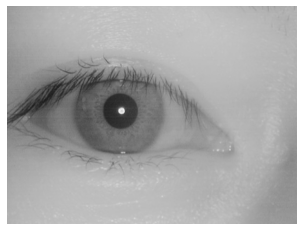

(480, 640, 3)


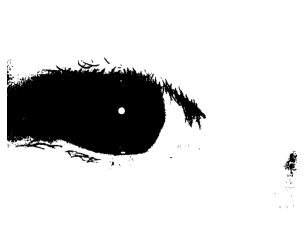

In [18]:
# /content/images/0000/0000_000.bmp
img = cv.imread('./images/0002/0002_001.bmp')
cv_imshow(img)
imgt = eq_bimodal(img)
print(imgt.shape)
cv_imshow(imgt)

### Aplicação de equalziação bimodal na imagem após CLAHE

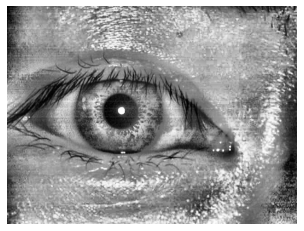

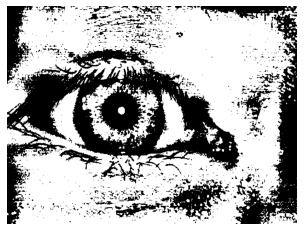

In [19]:
clahe_bgr = apply_clahe(img, clipLimit=20)
cv_imshow(clahe_bgr)
imgt2 = eq_bimodal(clahe_bgr)
cv_imshow(imgt2)

### Teste de processamento com imagem da base

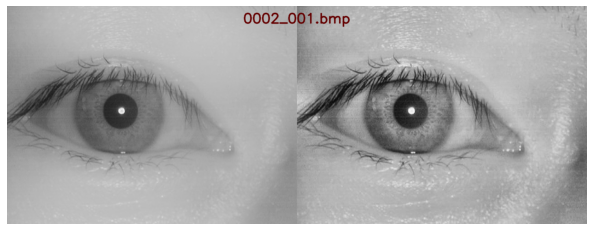

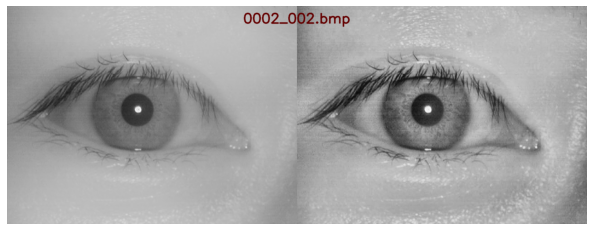

In [20]:
process_category(input_dir,'0002', save=False, show=True, limit=3, ignore_list=[0])

### Processamento das imagens

As categorias abaixo são processadas, mas algumas de suas imagens precisam ser ignoradas devido a falta de capacidade do algoritmo de reconhecimento de detectar pontos-chaves do olho.

In [24]:
process_category(input_dir,'0000', save=True, show=False, ignore_list=[2, 4, 5, 7, 13, 16, 17, 18, 19])
process_category(input_dir,'0001', save=True, show=False, ignore_list=[0, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19])
process_category(input_dir,'0002', save=True, show=False, ignore_list=[8, 12])
process_category(input_dir,'0003', save=True, show=False, ignore_list=[0, 4, 5, 7, 8, 10, 19])
process_category(input_dir,'0004', save=True, show=False, ignore_list=[0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

for i in range(5, 59):
    try:
        process_category(input_dir, str(i).zfill(4), save=True, show=False)
    except:
        continue
# process_category(input_dir,'0005', save=True, show=False, ignore_list=[])

### Treinamento das imagens processadas na etapa anterior

In [25]:
import G6_iris_recognition
G6_iris_recognition.iris_model_train(input_dir + '_tmp', "model.pickle")

directory_list ['images_tmp\\0000', 'images_tmp\\0001', 'images_tmp\\0002', 'images_tmp\\0003', 'images_tmp\\0004', 'images_tmp\\0005', 'images_tmp\\0006', 'images_tmp\\0007', 'images_tmp\\0008', 'images_tmp\\0009', 'images_tmp\\0010', 'images_tmp\\0011', 'images_tmp\\0013', 'images_tmp\\0014', 'images_tmp\\0015', 'images_tmp\\0016', 'images_tmp\\0017', 'images_tmp\\0018', 'images_tmp\\0019', 'images_tmp\\0020', 'images_tmp\\0021', 'images_tmp\\0022', 'images_tmp\\0023', 'images_tmp\\0024', 'images_tmp\\0025', 'images_tmp\\0026', 'images_tmp\\0027', 'images_tmp\\0028', 'images_tmp\\0029', 'images_tmp\\0030', 'images_tmp\\0031', 'images_tmp\\0032', 'images_tmp\\0033', 'images_tmp\\0034', 'images_tmp\\0035', 'images_tmp\\0036', 'images_tmp\\0037', 'images_tmp\\0038', 'images_tmp\\0039', 'images_tmp\\0040', 'images_tmp\\0041', 'images_tmp\\0042', 'images_tmp\\0043', 'images_tmp\\0044', 'images_tmp\\0045', 'images_tmp\\0046', 'images_tmp\\0047', 'images_tmp\\0048', 'images_tmp\\0049', 'ima

locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp\0007\0007_005.bmp
path_to_image images_tmp\0007\0007_006.bmp
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp\0007\0007_008.bmp
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp\0007\0007_009.bmp
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp\0007\0007_010.bmp
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp\0007\0007_011.bmp
locate expression 1 index 640 is

locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp\0013\0013_008.bmp
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp\0013\0013_009.bmp
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp\0013\0013_010.bmp
path_to_image images_tmp\0013\0013_011.bmp
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp\0013\0013_012.bmp
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp\0013\0013_013.bmp
locate expression 1 index 640 is

path_to_image images_tmp\0020\0020_015.bmp
path_to_image images_tmp\0020\0020_016.bmp
path_to_image images_tmp\0020\0020_017.bmp
path_to_image images_tmp\0020\0020_018.bmp
path_to_image images_tmp\0020\0020_019.bmp
invalid_image 0020
name 0021
path_to_image images_tmp\0021\0021_000.bmp
path_to_image images_tmp\0021\0021_001.bmp
path_to_image images_tmp\0021\0021_002.bmp
path_to_image images_tmp\0021\0021_003.bmp
path_to_image images_tmp\0021\0021_006.bmp
path_to_image images_tmp\0021\0021_007.bmp
path_to_image images_tmp\0021\0021_008.bmp
path_to_image images_tmp\0021\0021_009.bmp
locate expression 1 local variable 'east_mark' referenced before assignment
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp\0021\0021_012.bmp
path_to_image images_tmp\0021\0021_013.bmp
path_to_image images_tmp\0021\0021_014.bmp
path_to_image images_tmp\0021\0021_015.bmp
rectangle expression1
path_to_image images_tmp\0021\0021_016.bmp
path_to_image images_tmp\0021

locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
invalid_image 0025
name 0026
path_to_image images_tmp\0026\0026_000.bmp
path_to_image images_tmp\0026\0026_001.bmp
path_to_image images_tmp\0026\0026_002.bmp
path_to_image images_tmp\0026\0026_003.bmp
path_to_image images_tmp\0026\0026_004.bmp
path_to_image images_tmp\0026\0026_005.bmp
path_to_image images_tmp\0026\0026_006.bmp
path_to_image images_tmp\0026\0026_007.bmp
path_to_image images_tmp\0026\0026_008.bmp
path_to_image images_tmp\0026\0026_009.bmp
path_to_image images_tmp\0026\0026_010.bmp
path_to_image images_tmp\0026\0026_011.bmp
path_to_image images_tmp\0026\0026_012.bmp
path_to_image images_tmp\0026\0026_013.bmp
path_to_image images_tmp\0026\0026_014.bmp
path_to_image images_tmp\0026\0026_015.bmp
path_to_image images_tmp\0026\0026_016.bmp
path_to_image images_tmp\0026\0026_017.bmp
path_to_image images_tmp\0026\0026_018.bmp
path_to_imag

locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp\0031\0031_007.bmp
path_to_image images_tmp\0031\0031_008.bmp
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp\0031\0031_009.bmp
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp\0031\0031_010.bmp
path_to_image images_tmp\0031\0031_011.bmp
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp\0031\0031_012.bmp
rectangle expression1
path_to_image images_tmp\0031\0031_013.bmp
path_to_image images_tmp\0031\0031_014.bmp
locate expression 1 index 640 is out of bounds for axis 1 with siz

path_to_image images_tmp\0037\0037_006.bmp
path_to_image images_tmp\0037\0037_007.bmp
path_to_image images_tmp\0037\0037_008.bmp
path_to_image images_tmp\0037\0037_009.bmp
path_to_image images_tmp\0037\0037_010.bmp
path_to_image images_tmp\0037\0037_011.bmp
path_to_image images_tmp\0037\0037_012.bmp
path_to_image images_tmp\0037\0037_013.bmp
path_to_image images_tmp\0037\0037_014.bmp
path_to_image images_tmp\0037\0037_015.bmp
path_to_image images_tmp\0037\0037_016.bmp
path_to_image images_tmp\0037\0037_017.bmp
path_to_image images_tmp\0037\0037_018.bmp
path_to_image images_tmp\0037\0037_019.bmp
invalid_image 0037
name 0038
path_to_image images_tmp\0038\0038_000.bmp
path_to_image images_tmp\0038\0038_001.bmp
path_to_image images_tmp\0038\0038_002.bmp
path_to_image images_tmp\0038\0038_003.bmp
path_to_image images_tmp\0038\0038_004.bmp
path_to_image images_tmp\0038\0038_005.bmp
path_to_image images_tmp\0038\0038_006.bmp
path_to_image images_tmp\0038\0038_007.bmp
path_to_image images_tmp\

locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp\0043\0043_006.bmp
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp\0043\0043_007.bmp
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp\0043\0043_008.bmp
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp\0043\0043_009.bmp
rectangle expression1
path_to_image images_tmp\0043\0043_010.bmp
path_to_image images_tmp\0043\0043_011.bmp
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_im

path_to_image images_tmp\0046\0046_018.bmp
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp\0046\0046_019.bmp
invalid_image 0046
name 0047
path_to_image images_tmp\0047\0047_000.bmp
path_to_image images_tmp\0047\0047_001.bmp
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp\0047\0047_002.bmp
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp\0047\0047_003.bmp
path_to_image images_tmp\0047\0047_004.bmp
path_to_image images_tmp\0047\0047_005.bmp
path_to_image images_tmp\0047\0047_006.bmp
path_to_image images_tmp\0047\0047_007.bmp
path_to_image images_tmp\0047\0047_008.bmp
path_to_image images_tmp\0047\0047_009.bmp
path_to_image images_tmp\0047

path_to_image images_tmp\0052\0052_002.bmp
path_to_image images_tmp\0052\0052_003.bmp
path_to_image images_tmp\0052\0052_004.bmp
path_to_image images_tmp\0052\0052_005.bmp
path_to_image images_tmp\0052\0052_006.bmp
path_to_image images_tmp\0052\0052_007.bmp
path_to_image images_tmp\0052\0052_008.bmp
path_to_image images_tmp\0052\0052_009.bmp
path_to_image images_tmp\0052\0052_010.bmp
path_to_image images_tmp\0052\0052_011.bmp
path_to_image images_tmp\0052\0052_012.bmp
path_to_image images_tmp\0052\0052_013.bmp
path_to_image images_tmp\0052\0052_014.bmp
path_to_image images_tmp\0052\0052_015.bmp
path_to_image images_tmp\0052\0052_016.bmp
path_to_image images_tmp\0052\0052_017.bmp
path_to_image images_tmp\0052\0052_018.bmp
path_to_image images_tmp\0052\0052_019.bmp
name 0053
path_to_image images_tmp\0053\0053_000.bmp
path_to_image images_tmp\0053\0053_001.bmp
path_to_image images_tmp\0053\0053_002.bmp
path_to_image images_tmp\0053\0053_003.bmp
path_to_image images_tmp\0053\0053_004.bmp
p

path_to_image images_tmp\0058\0058_002.bmp
path_to_image images_tmp\0058\0058_003.bmp
path_to_image images_tmp\0058\0058_004.bmp
path_to_image images_tmp\0058\0058_005.bmp
path_to_image images_tmp\0058\0058_006.bmp
path_to_image images_tmp\0058\0058_007.bmp
path_to_image images_tmp\0058\0058_008.bmp
path_to_image images_tmp\0058\0058_009.bmp
path_to_image images_tmp\0058\0058_010.bmp
path_to_image images_tmp\0058\0058_011.bmp
path_to_image images_tmp\0058\0058_012.bmp
path_to_image images_tmp\0058\0058_013.bmp
path_to_image images_tmp\0058\0058_014.bmp
path_to_image images_tmp\0058\0058_015.bmp
path_to_image images_tmp\0058\0058_016.bmp
path_to_image images_tmp\0058\0058_017.bmp
path_to_image images_tmp\0058\0058_018.bmp
path_to_image images_tmp\0058\0058_019.bmp
train_db_model_path 14 14
[INFO] serializing encodings...
OK


['0000',
 '0001',
 '0002',
 '0003',
 '0004',
 '0016',
 '0026',
 '0028',
 '0036',
 '0038',
 '0040',
 '0050',
 '0052',
 '0058']

### Teste com as imagens

Teste e cálculo de score

In [ ]:
correct = 0
total = 0
    
for category in listdir("./images_tmp"):
    print("\nCategory", category)
    for img_name in listdir(f"./images_tmp/{category}"):
        iris_name = G6_iris_recognition.iris_model_test("model.pickle", f"./images_tmp/{category}/{img_name}")
        correct_answer = img_name.split('_')[0]
        print(f"{img_name} detected as '{iris_name}' and should be '{correct_answer}'")
        if correct_answer == iris_name:
            correct += 1
        total += 1

print(f"\ntotal: {total} | correct answers: {correct} | percentual: {100*correct/total}")


Category 0000
0000_000.bmp detected as '0001' and should be '0000'
0000_001.bmp detected as '0001' and should be '0000'
0000_003.bmp detected as '0001' and should be '0000'
0000_006.bmp detected as '0001' and should be '0000'
0000_008.bmp detected as '0001' and should be '0000'
0000_009.bmp detected as '0001' and should be '0000'
0000_010.bmp detected as '0001' and should be '0000'
0000_011.bmp detected as '0004' and should be '0000'
0000_012.bmp detected as '0001' and should be '0000'
0000_014.bmp detected as '0004' and should be '0000'
0000_015.bmp detected as '0001' and should be '0000'

Category 0001
0001_001.bmp detected as '0001' and should be '0001'
0001_002.bmp detected as '0001' and should be '0001'
0001_003.bmp detected as '0001' and should be '0001'
0001_012.bmp detected as '0001' and should be '0001'

Category 0002
0002_000.bmp detected as '0001' and should be '0002'
0002_001.bmp detected as '0001' and should be '0002'
0002_002.bmp detected as '0001' and should be '0002'
0

0007_005.bmp detected as '0001' and should be '0007'
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
0007_006.bmp detected as 'unmatch' and should be '0007'
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
0007_008.bmp detected as 'unmatch' and should be '0007'
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
0007_009.bmp detected as 'unmatch' and should be '0007'
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
0007_010.bmp detected as 'unmatch' and should be '0007'
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
0007_011.bmp 

locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
0013_003.bmp detected as 'unmatch' and should be '0013'
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
0013_004.bmp detected as 'unmatch' and should be '0013'
0013_005.bmp detected as '0001' and should be '0013'
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
0013_006.bmp detected as 'unmatch' and should be '0013'
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
0013_007.bmp detected as 'unmatch' and should be '0013'
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
0013_008.bmp 

0018_016.bmp detected as '0001' and should be '0018'
0018_017.bmp detected as '0001' and should be '0018'
0018_018.bmp detected as '0001' and should be '0018'
0018_019.bmp detected as '0001' and should be '0018'

Category 0019
0019_000.bmp detected as '0001' and should be '0019'
0019_001.bmp detected as '0001' and should be '0019'
0019_002.bmp detected as '0001' and should be '0019'
0019_003.bmp detected as '0001' and should be '0019'
0019_004.bmp detected as '0001' and should be '0019'
0019_005.bmp detected as '0001' and should be '0019'
0019_006.bmp detected as '0001' and should be '0019'
0019_007.bmp detected as '0001' and should be '0019'
0019_008.bmp detected as '0001' and should be '0019'
0019_009.bmp detected as '0001' and should be '0019'
0019_010.bmp detected as '0004' and should be '0019'
0019_011.bmp detected as '0004' and should be '0019'
rectangle expression1
0019_012.bmp detected as 'unmatch' and should be '0019'
0019_013.bmp detected as '0001' and should be '0019'
0019_0

locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
0025_003.bmp detected as 'unmatch' and should be '0025'
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
0025_004.bmp detected as 'unmatch' and should be '0025'
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
0025_005.bmp detected as 'unmatch' and should be '0025'
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
0025_006.bmp detected as 'unmatch' and should be '0025'
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
0025_007.bmp detected as 'unmatch' and should be '0025'
locate exp

0028_007.bmp detected as '0001' and should be '0028'
0028_008.bmp detected as '0004' and should be '0028'
0028_009.bmp detected as '0004' and should be '0028'
0028_010.bmp detected as '0001' and should be '0028'
0028_011.bmp detected as '0001' and should be '0028'
0028_012.bmp detected as '0001' and should be '0028'
0028_013.bmp detected as '0001' and should be '0028'
0028_014.bmp detected as '0001' and should be '0028'
0028_015.bmp detected as '0001' and should be '0028'
0028_016.bmp detected as '0001' and should be '0028'
0028_017.bmp detected as '0001' and should be '0028'
0028_018.bmp detected as '0001' and should be '0028'
0028_019.bmp detected as '0001' and should be '0028'

Category 0029
0029_000.bmp detected as '0001' and should be '0029'
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
0029_001.bmp detected as 'unmatch' and should be '0029'
0029_002.bmp detected as '0001' and should be

locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
0033_006.bmp detected as 'unmatch' and should be '0033'
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
0033_007.bmp detected as 'unmatch' and should be '0033'
0033_008.bmp detected as '0001' and should be '0033'
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
0033_009.bmp detected as 'unmatch' and should be '0033'
0033_010.bmp detected as '0001' and should be '0033'
0033_011.bmp detected as '0001' and should be '0033'
0033_012.bmp detected as '0001' and should be '0033'
0033_013.bmp detected as '0001' and should be '0033'
0033_014.bmp detected as '0001' and should be '0033'
0033_015.bmp detected as '0001' and should be '0033'
0033_016.bmp detected as '0001' and

### Resultado

Após a tentativa de ajuste de alguns dos parâmentros da função de processamento, percebemos que os melhores resultados foram obitidos quando apenas a transformação de CLAHE era utilizada. Isso indica que talvez fosse melhor alterar a ordem das transformações ou reajustar cada parâmetro e **de acordo com a categoria**.